# Clustering

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.special as sp
import pycodamath as coda
from pycodamath import plot
from pycodamath import extra
from statsmodels.formula.api import ols
import scipy.optimize as optimization

#### 1. Data Loading

In [29]:
import pandas as pd
import re

# Load data
data = pd.read_csv('../data/2-meteorites.csv', sep=',')
data.rename(columns={'Unnamed: 0': 'Location'}, inplace=True)

# Strip leading and trailing spaces from all column names
data.columns = data.columns.str.strip()

# Extract the part inside parentheses into 'Type'
data['Type'] = data['Location'].str.extract(r'\((.*?)\)')

# Remove the parentheses and content from 'Location'
data['Location'] = data['Location'].str.replace(r'\s*\(.*?\)', '', regex=True).str.strip()

# Reorder columns: Location, Type, then the rest
cols = ['Location', 'Type'] + [col for col in data.columns if col not in ['Location', 'Type']]
data = data[cols]


data['Oxides'] = data[['SiO2', 'Al2O3', 'FeO', 'MnO', 'MgO']].sum(axis=1)
data['Metals'] = data[['Fe', 'Ni', 'Co']].sum(axis=1)
data['Carbon'] = data['C']

#First closure on the original parts
data.iloc[:, 2:-3] = data.iloc[:, 2:-1].coda.closure(100)
#Then closure on the new parts
data.iloc[:, -4:] = data.iloc[:, -4:].coda.closure(100)

# Check result
print(data.head())
print(data.shape)


    Location Type       SiO2     Al2O3        FeO       MnO        MgO  \
0    Allende   cc  18.988184  1.813946  15.060742  0.099850  13.657292   
1       Bali   cc  19.007148  1.778578  14.920921  0.106940  13.812124   
2  Efremovka   cc  19.695752  1.934558   9.873708  0.109070  14.184845   
3   Coolidge   cc  21.505779  2.068104   4.536082  0.149953  15.613871   
4    Ankober   hc  19.700178  1.292911   7.272626  0.178333  12.739634   

         Fe        Ni        Co         C     Oxides     Metals    Carbon  
0  0.094303  0.199700  0.005547  0.177873  98.904400   0.597075  0.320651  
1  0.084426  0.123825  0.005628  0.358695  98.579150   0.424862  0.637293  
2  3.163031  0.786452  0.034443  0.496245  90.745423   7.893874  0.864459  
3  5.173383  0.843486  0.049984  0.147950  87.513866  12.101391  0.236793  
4  7.779759  0.952965  0.055729  0.062041  82.270415  17.556217  0.111327  
(12, 14)


In [30]:

response = data[['Oxides', 'Metals', 'Carbon']]
covariates = data[['Type']]  # cc, hc, lc


balance = [[1,1,-1],[1,-1,0]]

In [31]:

# Normalize to get orthonormal basis
psi = coda.extra.norm(balance)

In [ ]:

# ILR transform
ilr = response.coda.ilr(psi)
ilr = ilr.rename(columns={0: 'ilr0', 1: 'ilr1'})

# Attach covariate (Type)
ilr['covariates'] = covariates['Type']
print(ilr)

# === Compute beta coefficients ===
beta = [ols(part + ' ~ covariates', data=ilr).fit().params[1] for part in ilr.columns[:-1]]
beta = pd.DataFrame(beta, columns=['beta'], index=ilr.columns[:-1]).T

# Back-transform to CLR
clrbeta = pd.DataFrame(np.dot(beta, psi), index=['clrbeta'], columns=response.columns)
print('\n--- CLR beta coefficients (sorted) ---')
print(clrbeta.iloc[0].sort_values())


        ilr0      ilr1 covariates
0   2.593700  3.613221         cc
1   1.892607  3.851505         cc
2   2.802808  1.726734         cc
3   4.019715  1.398994         cc
4   4.762621  1.092200         hc
5   4.396055  1.089293         hc
6   6.716871  0.924099         hc
7   4.492074  0.961314         hc
8   3.017040  2.406109         lc
9   3.568428  1.644521         lc
10  3.804869  1.429459         lc
11  3.747116  1.607727         lc

--- CLR beta coefficients (sorted) ---
Carbon   -1.849118
Oxides   -0.228653
Metals    2.077771
Name: clrbeta, dtype: float64


/tmp/ipykernel_82814/2540539654.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = [ols(part + ' ~ covariates', data=ilr).fit().params[1] for part in ilr.columns[:-1]]
/tmp/ipykernel_82814/2540539654.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = [ols(part + ' ~ covariates', data=ilr).fit().params[1] for part in ilr.columns[:-1]]


In [36]:
import pandas as pd
import numpy as np
from statsmodels.formula.api import ols

# Assume `response` and `covariates` are already set:
# response = data[['Oxides', 'Metals', 'Carbon']]
# covariates = data[['Type']]

# Define balances
balance = [[1, 1, -1], [1, -1, 0]]
psi = coda.extra.norm(balance)

# ILR transform
ilr = response.coda.ilr(psi)
ilr = ilr.rename(columns={0: 'ilr0', 1: 'ilr1'})
ilr['Type'] = covariates['Type']

# Initialize lists for storing both contrasts
beta_hc = []
beta_lc = []

# For each ILR balance, extract hc vs cc and lc vs cc
for part in ilr.columns[:-1]:
    model = ols(f'{part} ~ Type', data=ilr).fit()
    beta_hc.append(model.params.get('Type[T.hc]', np.nan))
    beta_lc.append(model.params.get('Type[T.lc]', np.nan))

# Convert to DataFrames
beta_hc_df = pd.DataFrame(beta_hc, columns=['beta_hc'], index=ilr.columns[:-1]).T
beta_lc_df = pd.DataFrame(beta_lc, columns=['beta_lc'], index=ilr.columns[:-1]).T

# Back-transform to CLR coefficients
clrbeta_hc = pd.DataFrame(np.dot(beta_hc_df, psi), index=['clr_beta_hc'], columns=response.columns)
clrbeta_lc = pd.DataFrame(np.dot(beta_lc_df, psi), index=['clr_beta_lc'], columns=response.columns)

# Print sorted results
print('\n--- CLR beta coefficients (hc vs cc, sorted) ---')
print(clrbeta_hc.iloc[0].sort_values())

print('\n--- CLR beta coefficients (lc vs cc, sorted) ---')
print(clrbeta_lc.iloc[0].sort_values())



--- CLR beta coefficients (hc vs cc, sorted) ---
Carbon   -1.849118
Oxides   -0.228653
Metals    2.077771
Name: clr_beta_hc, dtype: float64

--- CLR beta coefficients (lc vs cc, sorted) ---
Carbon   -0.57739
Oxides   -0.33049
Metals    0.90788
Name: clr_beta_lc, dtype: float64


In [40]:

# === Redefine balances for new grouping ===

balance = [[1,-1,1],[1,0,-1]]


# Normalize new balances
psi = coda.extra.norm(balance)

# ILR transform with new balances
ilr = response.coda.ilr(psi)
ilr = ilr.rename(columns={0: 'ilr0', 1: 'ilr1'})
ilr['Type'] = covariates['Type']

# === Run ANOVA per balance and extract both contrasts ===
print('\n--- ANOVA per ILR balance ---')
for part in ilr.columns[:-1]:
    model = ols(f'{part} ~ Type', data=ilr).fit()
    intercept = model.params.get('Intercept', np.nan)
    beta_hc = model.params.get('Type[T.hc]', np.nan)
    beta_lc = model.params.get('Type[T.lc]', np.nan)
    t_value = np.sqrt(model.fvalue)
    p_value = model.f_pvalue
    
    print(f'{part}')
    print(f'Intercept (cc): {intercept:.4f}')
    print(f'Beta hc vs cc: {beta_hc:.4f}')
    print(f'Beta lc vs cc: {beta_lc:.4f}')
    print(f't-value: {t_value:.4f}')
    print(f'p-value: {p_value:.4f}')
    print()



--- ANOVA per ILR balance ---
ilr0
Intercept (cc): 0.8793
Beta hc vs cc: -2.5447
Beta lc vs cc: -1.1119
t-value: 2.6074
p-value: 0.0159

ilr1
Intercept (cc): 3.7722
Beta hc vs cc: 1.1458
Beta lc vs cc: 0.1746
t-value: 2.1083
p-value: 0.0454



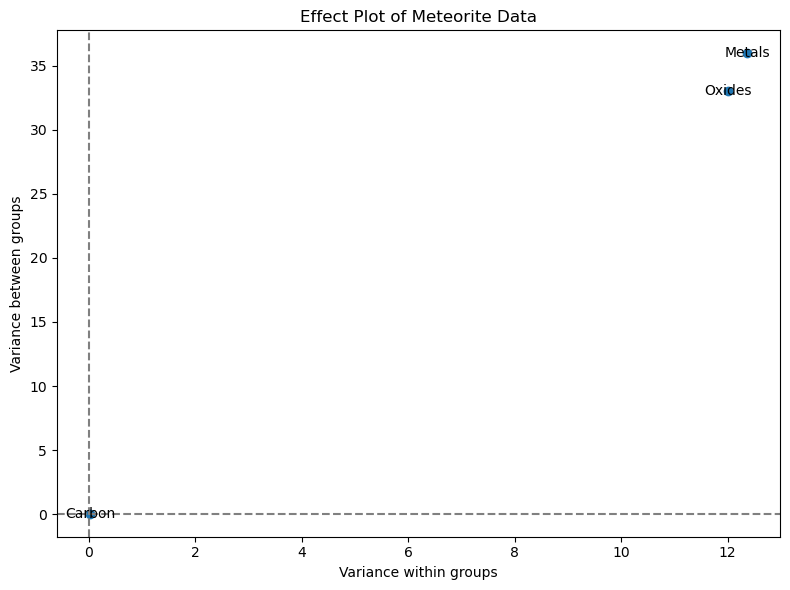

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assume `data` has: Type (cc/hc/lc), and amalgamated columns Oxides, Metals, Carbon
parts = ['Oxides', 'Metals', 'Carbon']
group_col = 'Type'

# Calculate overall means
overall_means = data[parts].mean()

# Initialize storage
within_var = []
between_var = []

# Calculate variance components
for part in parts:
    # Group means
    group_means = data.groupby(group_col)[part].mean()
    # Group sizes
    group_sizes = data.groupby(group_col).size()
    
    # Between-group variance
    between = np.sum(group_sizes * (group_means - overall_means[part])**2) / len(data)
    between_var.append(between)
    
    # Within-group variance
    within = 0
    for g in data[group_col].unique():
        group_data = data[data[group_col] == g][part]
        within += np.sum((group_data - group_means[g])**2)
    within /= len(data)
    within_var.append(within)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(within_var, between_var)

for i, part in enumerate(parts):
    plt.text(within_var[i], between_var[i], part, fontsize=10, ha='center', va='center')

plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
plt.xlabel('Variance within groups')
plt.ylabel('Variance between groups')
plt.title('Effect Plot of Meteorite Data')
plt.tight_layout()
plt.show()
